In [15]:
from ctypes import sizeof
from tabnanny import verbose
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.operators import PolynomialTensor
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from pyscf.lo import Boys
from pyscf.lo import PM
from qiskit_nature.units import DistanceUnit
import numpy as np  
from pyscf.tools import molden

In [16]:
fci_energies=[]
fci_ecores=[]

In [17]:
dist_oh=0.96
for dist_oh in [0.75,0.8,0.85, 0.9, 0.95, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.95, 2.1, 2.25, 2.4, 2.55,2.7, 2.85, 3.0]:

        angle_hoh=104.5

        # Calculate H positions
        theta = np.radians(angle_hoh / 2)
        x = dist_oh * np.cos(theta)
        y = dist_oh * np.sin(theta)
        
        # Define H₂O geometry
        atom = f"""O  0.0  0.0  0.0;H  {x:.3f}  {y:.3f}  0.0;H  {-x:.3f}  {y:.3f}  0.0"""
        
        # Set up driver and problem
        driver = PySCFDriver(
                atom=atom,
                basis="cc-pvdz",
                charge=0,
                spin=0,
                unit=DistanceUnit.ANGSTROM
        )
        problem = driver.run()
        # Active space: O 2p (2,3,4) and H 1s (5,6)
        transformer = ActiveSpaceTransformer(
                num_electrons=8,            # 4 (O 2p) + 2 (H 1s)
                num_spatial_orbitals=6,     # 3 (O 2p) + 2 (H 1s)
        )
        problem_reduced = transformer.transform(problem)
        
        # Get Hamiltonian (already includes nuclear repulsion energy)
        hamiltonian = problem_reduced.hamiltonian
        fermionic_op = problem_reduced.hamiltonian.second_q_op()
        mapper = JordanWignerMapper()
        tapered_mapper = problem_reduced.get_tapered_mapper(mapper)
        qubit_op = tapered_mapper.map(fermionic_op)
        # print(qubit_op)
        filename = f"qubit_op_h2o_tapered_{dist_oh:.2f}.npy"
        np.save(filename, qubit_op)
        eigenvalues, eigenvectors=np.linalg.eig(qubit_op.to_matrix())
        print(np.min(eigenvalues))
        fci_energies.append(np.min(eigenvalues))
        ecore = problem_reduced.hamiltonian.constants
        print("Core energy (ecore):", ecore)    
        fci_ecores.append(ecore)
    


(-25.783945226620094+0j)
Core energy (ecore): {'nuclear_repulsion_energy': 11.867265893794634, 'ActiveSpaceTransformer': -61.927464875132756}
(-25.290077647843813+0j)
Core energy (ecore): {'nuclear_repulsion_energy': 11.11700322717542, 'ActiveSpaceTransformer': -61.74913765925405}
(-24.846324574423075+0j)
Core energy (ecore): {'nuclear_repulsion_energy': 10.4733659429331, 'ActiveSpaceTransformer': -61.5961236099196}
(-24.424443456192037+0j)
Core energy (ecore): {'nuclear_repulsion_energy': 9.884628662365518, 'ActiveSpaceTransformer': -61.45619379133461}
(-24.040558551100254+0j)
Core energy (ecore): {'nuclear_repulsion_energy': 9.365967122621306, 'ActiveSpaceTransformer': -61.3330069116534}
(-23.684907470550762+0j)
Core energy (ecore): {'nuclear_repulsion_energy': 8.898217339094849, 'ActiveSpaceTransformer': -61.221715136856275}
(-23.0522646221075+0j)
Core energy (ecore): {'nuclear_repulsion_energy': 8.090815015372788, 'ActiveSpaceTransformer': -61.02978141729595}
(-22.506276274302856+0

In [18]:
print("FCI energies:", fci_energies)
print("FCI core energies:", fci_ecores)

FCI energies: [(-25.783945226620094+0j), (-25.290077647843813+0j), (-24.846324574423075+0j), (-24.424443456192037+0j), (-24.040558551100254+0j), (-23.684907470550762+0j), (-23.0522646221075+0j), (-22.506276274302856+0j), (-22.039134229282276+0j), (-21.634303229796963+0j), (-21.281393777491033+0j), (-20.970157320720084+0j), (-20.69798158879089+0j), (-20.457160527710293+0j), (-20.143593851737506+7.680804131982973e-16j), (-19.880176149373312+0j), (-19.655540198756274+0j), (-19.460915841384992+0j), (-19.30289142894834+1.835816103125301e-15j), (-19.122960215936843+4.501049924019813e-19j), (-19.009897422744757+0j), (-18.889748996256568-2.2713285958689374e-17j)]
FCI core energies: [{'nuclear_repulsion_energy': 11.867265893794634, 'ActiveSpaceTransformer': -61.927464875132756}, {'nuclear_repulsion_energy': 11.11700322717542, 'ActiveSpaceTransformer': -61.74913765925405}, {'nuclear_repulsion_energy': 10.4733659429331, 'ActiveSpaceTransformer': -61.5961236099196}, {'nuclear_repulsion_energy': 9.

In [19]:
import matplotlib.pyplot as plt

fci_total = []
for i in range(len(fci_energies)):
    # Extract core energies from dictionary
    nuclear_repulsion = fci_ecores[i]['nuclear_repulsion_energy']
    core_correction = fci_ecores[i]['ActiveSpaceTransformer']
    # Add all contributions to get total energy
    fci_energies_tot = fci_energies[i].real + nuclear_repulsion + core_correction
    fci_total.append(fci_energies_tot)

print("FCI total energies:", fci_total)
print(np.shape(fci_total))

distance=[0.75,0.8,0.85, 0.9, 0.95, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.95, 2.1, 2.25, 2.4, 2.55,2.7, 2.85, 3.0]
print(np.shape(distance))

FCI total energies: [-75.84414420795821, -75.92221207992245, -75.96908224140958, -75.99600858516114, -76.00759834013235, -76.00840526831219, -75.99123102403067, -75.96149255240897, -75.9281263343952, -75.89521967102709, -75.86473102552768, -75.83747165053745, -75.81412169692943, -75.79451994495558, -75.77155088017261, -75.75595848480923, -75.74625438904076, -75.74053954239012, -75.74857490428963, -75.71659727297876, -75.73545944997498, -75.73461744710642]
(22,)
(22,)


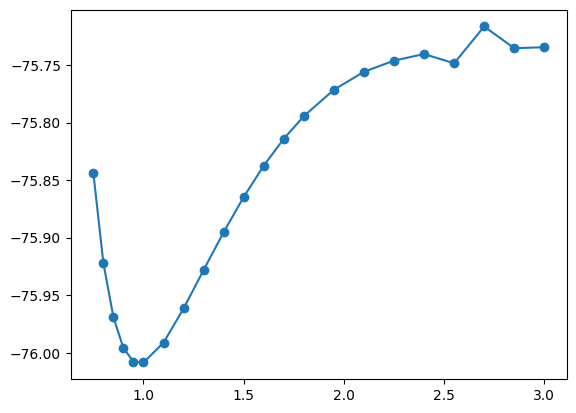

In [20]:
plt.plot(distance, fci_total, marker='o', label='FCI Total Energy')